In [ ]:
# Data Source
# 1. CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html Accessed on 2024 11 11
#   - Files: data_batch_1, data_batch_2, data_batch_3, data_batch_4, data_batch_5, test_batch
#   - Renamed to: cifar10-train-1, cifar10-train-2, cifar10-train-3, cifar10-train-4, cifar10-train-5, cifar10-test

# 2. Fashion-MNIST: https://github.com/zalandoresearch/fashion-mnist Accessed on 2024 11 11
#   - Files: train-images-idx3-ubyte, train-labels-idx1-ubyte, t10k-images-idx3-ubyte, t10k-labels-idx1-ubyte
#   - Renamed to: fmnist-train-image, fmnist-train-label, fmnist-test-image, fmnist-test-label

In [ ]:
# Importing Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import setuptools.dist  # To avoid tensorflow import error for distutils, requires setuptools to be installed
import tensorflow as tf

CIFAR-10 - Train


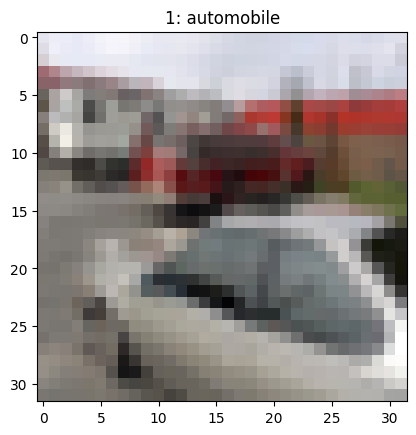

CIFAR-10 - Test


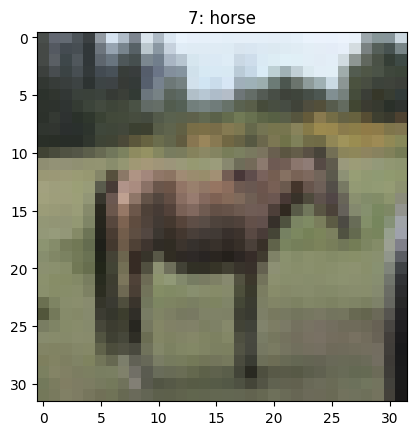

Fashion MNIST - Train


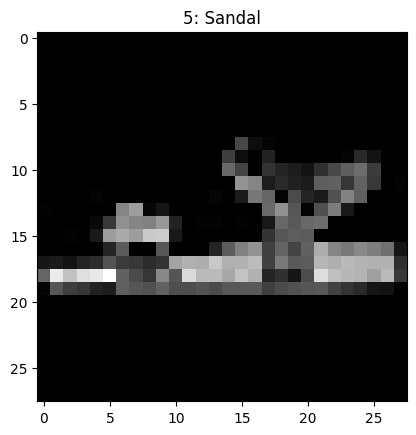

Fashion MNIST - Test


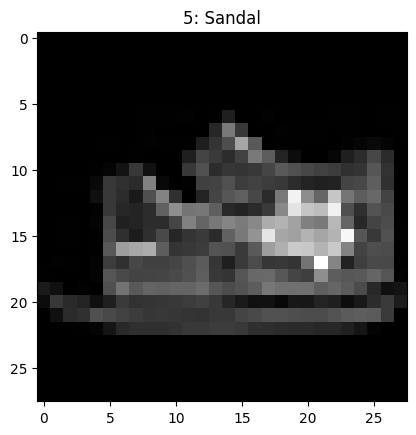

In [9]:
# ==================================================================================================== Step 1. Loading Data
# 1. CIFAR-10 Ref: https://www.cs.toronto.edu/~kriz/cifar.html

# CIFAR-10 Class Label
cifar10_classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]


# For loading pickle files. From https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle

    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict


# For displaying cifar10 image
def cifar10_display_image(data, label, index=0):
    image = data[index].reshape(3, 32, 32).transpose(1, 2, 0)
    label_class = label[index]
    label_name = cifar10_classes[label_class]
    full_label = f"{label_class}: {label_name}"
    plt.imshow(image)
    plt.title(full_label)
    plt.show()


cifar10_train_data = []
cifar10_train_label = []

cifar10_test_data = []
cifar10_test_label = []

# 1.1 Load Train Data
for i in range(1, 6):
    file = f"./data/cifar10-train-{i}"
    cifar10_test_file = unpickle(file)
    cifar10_train_data.append(cifar10_test_file[b"data"])
    cifar10_train_label.append(cifar10_test_file[b"labels"])

cifar10_train_data = np.concatenate(cifar10_train_data)
cifar10_train_label = np.concatenate(cifar10_train_label)

# 1.2 Load Test Data
cifar10_test_file = unpickle("./data/cifar10-test")
cifar10_test_data.append(cifar10_test_file[b"data"])
cifar10_test_label.append(cifar10_test_file[b"labels"])

cifar10_test_data = np.concatenate(cifar10_test_data)
cifar10_test_label = np.concatenate(cifar10_test_label)

# 1.3 Display image with label and class (for testing)
print("CIFAR-10 - Train")
# cifar10_display_image(cifar10_train_data, cifar10_train_label, 0)
cifar10_display_image(cifar10_train_data, cifar10_train_label, 49999)
print("CIFAR-10 - Test")
# cifar10_display_image(cifar10_test_data, cifar10_test_label, 0)
cifar10_display_image(cifar10_test_data, cifar10_test_label, 9999)


# 2. Fashion-MNIST Ref: https://pjreddie.com/projects/mnist-in-csv/ , https://www.kaggle.com/code/pavansanagapati/a-simple-cnn-model-beginner-guide

# Fashion MNIST Class Label
fmnist_classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]


# For converting idx to csv
def idx2csv(image_file, label_file, output_file):
    with open(image_file, "rb") as f:
        image_data = f.read()
    with open(label_file, "rb") as f:
        label_data = f.read()

    # Skip header
    image_data = image_data[16:]
    label_data = label_data[8:]

    image_length = len(image_data) // 784  # 28x28 = 784
    label_length = len(label_data)  # 1 byte per label

    images = np.zeros((image_length, 784), dtype=np.uint8)  # 28x28 = 784
    labels = np.zeros((label_length), dtype=np.uint8)  # 1 byte per label

    # i = image index, j = pixel index
    for i in range(image_length):
        for j in range(784):
            images[i, j] = image_data[i * 784 + j]  # 28x28 = 784

    # i = label index
    for i in range(label_length):
        labels[i] = label_data[i]  # 1 byte per label

    # Save to csv
    np.savetxt(
        output_file,
        np.concatenate((labels.reshape(-1, 1), images), axis=1),
        delimiter=",",
        fmt="%d",
    )


# For displaying fmnist image
def fmnist_display_image(data, label, index=0):
    image = data[index].reshape(28, 28)
    label_class = label[index]
    label_name = fmnist_classes[label_class]
    full_label = f"{label_class}: {label_name}"
    plt.imshow(image, cmap="gray")
    plt.title(full_label)
    plt.show()


# 2.1 Convert idx to csv
if not os.path.exists("./data/fmnist-train.csv"):
    idx2csv(
        "./data/fmnist-train-image",
        "./data/fmnist-train-label",
        "./data/fmnist-train.csv",
    )
if not os.path.exists("./data/fmnist-test.csv"):
    idx2csv(
        "./data/fmnist-test-image", "./data/fmnist-test-label", "./data/fmnist-test.csv"
    )

# 2.2 Load Data
fmnist_train = pd.read_csv("./data/fmnist-train.csv", header=None)
fmnist_test = pd.read_csv("./data/fmnist-test.csv", header=None)

fmnist_train_data = fmnist_train.iloc[:, 1:].values
fmnist_train_label = fmnist_train.iloc[:, 0].values

fmnist_test_data = fmnist_test.iloc[:, 1:].values
fmnist_test_label = fmnist_test.iloc[:, 0].values


# 2.3 Display image with label and class (for testing)
print("Fashion MNIST - Train")
# fmnist_display_image(fmnist_train_data, fmnist_train_label, 0)
fmnist_display_image(fmnist_train_data, fmnist_train_label, 59999)
print("Fashion MNIST - Test")
# fmnist_display_image(fmnist_test_data, fmnist_test_label, 0)
fmnist_display_image(fmnist_test_data, fmnist_test_label, 9999)

In [ ]:
# 